# Plateforme et language de programmation : Mini-projet final 
Mathieu Chalvidal 

# Consigne

Mini projet d'analyse de données massives à l'image du cas CDiscount : analyse comparative de la chaîne no big data versus la chaîne avec Spark. Le jeu de données est à votre choix. Il faut qu'il soit suffisamment volumineux.

## Use case presentation : Clustering, dimensionnality reduction and meaning embeddings for the Seatle Library Inventory

#### Kaggle description 

This dataset comes from the **Kaggle Dataset bank**. This is a dataset hosted by the City of Seattle. The city has an open data platform and they update their information according the amount of data that is brought in. Explore the City of Seattle using Kaggle and all of the data sources available through the City of Seattle organization page!

#### Content

The dataset consists in the **recording of all Seatle library entries (Title, summary, keywords)** (6GB ~A few millions rows) The goal of this use case is to eplore the relational modelisation of those recording in order to produce relevant browsing methods. Thoses tasks we'll help us in understanding the efficiency of the distributed formulation of algorithms thanks to the use of $\color{red}{pyspark}$ against $\color{green}{pandas}$ and $\color{green}{Scikit learn}$.

Namely we'll implement **a querying tool to retrieve relevant content from the database based on keywords queries from user**. To this end, we build a similarity model based on Word2Vec n_grams embeddings of words of the database. Then a cosine similarity performed on all the database enable us to score and rank content. In addition, we'll eplore the computation efficiency of Spark and Scikit on other tasks such as **K-Means clusterisation of the database and a dimensionnality reduction algorithm**.

The models we are introducing: 

- **Word2Vec n_grams vectorization of library**
- **Cosine_similarity and relevancy ranking** 
- **K_means for clustering**
- **Dimensionnality reduction (PCA and TSNE)**


**Data schema**

- **Title** (string) : The full title of an item (string)
- **Id** (int) :  The number of identification for the Seattle library.
- **labels** (string): A separated list of the subject authority records associated with the title

# Results 

#### N = 10 000 rows

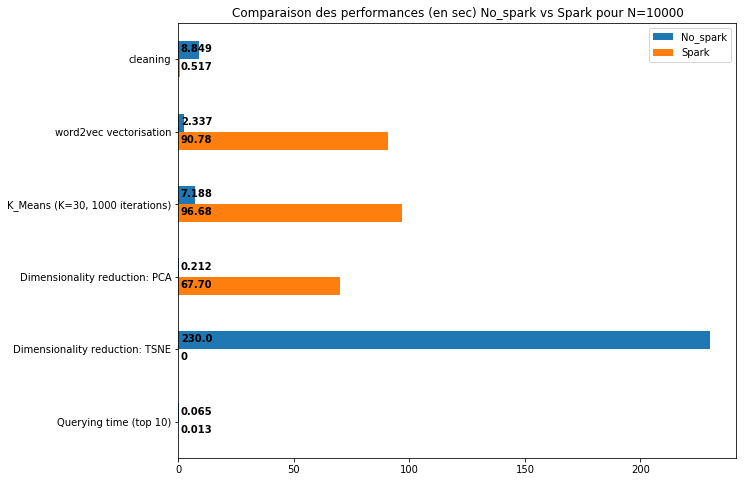

In [10]:
import os
from IPython.display import Image
os.chdir('/Users/chalvidalm/Documents/3A OMA/Plateforme et Langage de Programmation/Etude_de_cas')
Image(filename='performance temporelle.png')

#### N = 100 000 rows

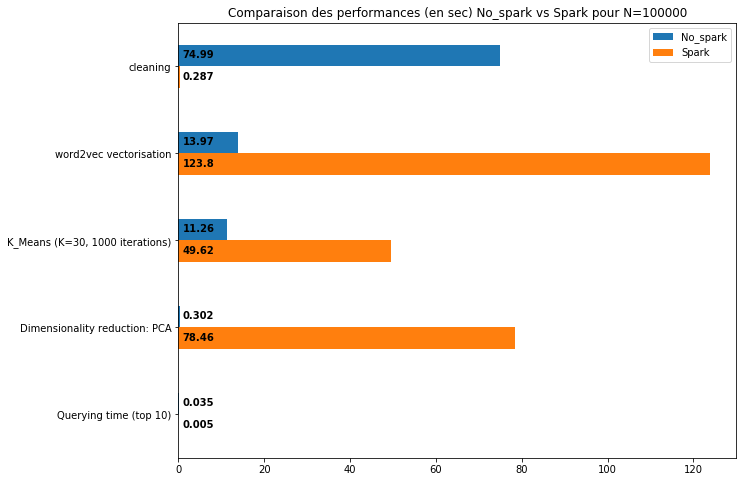

In [173]:
os.chdir('/Users/chalvidalm/Documents/3A OMA/Plateforme et Langage de Programmation/Etude_de_cas')
Image(filename='performance temporelle_100K.png')

#### N = 500 000 rows

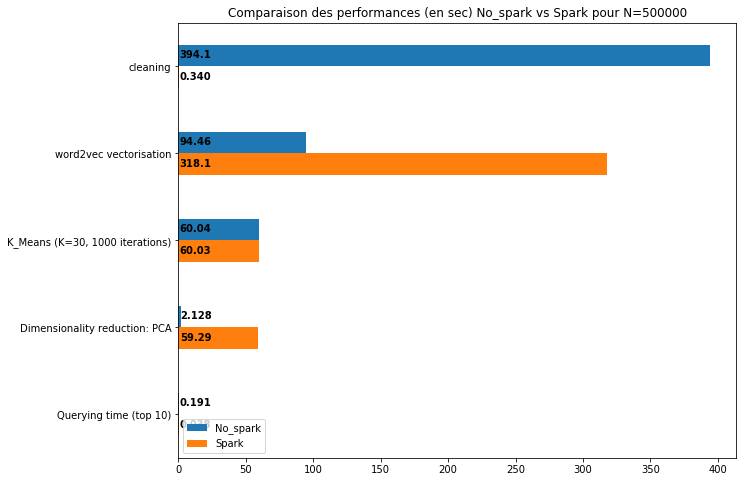

In [205]:
os.chdir('/Users/chalvidalm/Documents/3A OMA/Plateforme et Langage de Programmation/Etude_de_cas')
Image(filename='performance temporelle_500K.png')

# I ) Traitement au moyen des librairies Pandas et Scikit-learn

#### Imports

In [16]:
import numpy as np
import pandas as pd
import nltk 
import time
import os
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
import re

In [4]:
os.chdir('/Users/chalvidalm/Documents/3A OMA/Plateforme et Langage de Programmation/Etude_de_cas/titlebased-semantic-subject-indexing')
Data = pd.read_csv('pubmed.csv', nrows = 1000000) #to be changed
Data.to_csv('pubmed_1M.csv')
Data.head(10)

,id,title,labels,fold
0,11882252,"CFEOM1, the classic familial form of congenita...",Female\tFibrosis\tGenetic Linkage\tGenetic Var...,3
1,11882251,An algorithm and program for finding sequence ...,Algorithms\tComputational Biology\tCupriavidus...,0
2,11922865,Nerve growth factor selectively regulates expr...,Animals\tGene Expression Profiling\tGene Expre...,0
3,11879527,The use of breast conserving surgery: linking ...,"Age Factors\tAged\tAged, 80 and over\tBreast N...",0
4,11914147,Assessment of the infectious diseases surveill...,Armenia\tCommunicable Disease Control\tDisease...,7
5,11884248,Reporting of measures of accuracy in systemati...,Bias (Epidemiology)\tClinical Laboratory Techn...,1
6,11914137,Markers for early detection of cancer: statist...,Bias (Epidemiology)\tBiomarkers\tCase-Control ...,9
7,11918830,A theoretical model for estimating the margina...,Animals\tCell Movement\tEpinephrine\tLeukocyte...,9
8,11914159,Tetraethylammonium block of water flux in Aqua...,Animals\tAquaporin 1\tAquaporins\tCell Line\tC...,1
9,11914123,Ca2+-mediated activation of ERK in hepatocytes...,Animals\tCalcimycin\tCalcium\tCalcium-Calmodul...,8


## a - Cleaning of the dataset

In [208]:
Stopwords = stopwords.words('English')
Sno = nltk.stem.SnowballStemmer('english')

def clean_txt(txt):
    txt = BeautifulSoup(txt,"html.parser").get_text()
    txt.lower()
    txt = re.sub(r'[^a-zA-Z0-9_]', ' ', txt)
    txt = re.sub(' +',';', txt)
    tokens = [terme for terme in txt.split(';') if terme not in Stopwords]
    termes = [Sno.stem(token) for token in tokens]
    clean = ' '.join(termes)
    return(clean)

def clean_dataframe(input_data, col_name):
    start = time.time()
    input_data["{}_clean".format(str(col_name))] = input_data[str(col_name)].apply(clean_txt)
    tim = time.time() - start
    return(tim)

t_cleaning_1000_scikit = clean_dataframe(Data,'title')
print('Cleaning done in {} sec'.format(t_cleaning_1000_scikit))

Cleaning done in 7.737925052642822 sec


In [209]:
Data_split = pd.concat([Data, Data['labels'].str.replace('\t',' ')], axis=1)
Data_split.head(10)

,id,title,labels,fold,title_clean,labels
0,11882252,"CFEOM1, the classic familial form of congenita...",Female\tFibrosis\tGenetic Linkage\tGenetic Var...,3,cfeom1 classic famili form congenit fibrosi ex...,Female Fibrosis Genetic Linkage Genetic Variat...
1,11882251,An algorithm and program for finding sequence ...,Algorithms\tComputational Biology\tCupriavidus...,0,an algorithm program find sequenc specif oligo...,Algorithms Computational Biology Cupriavidus n...
2,11922865,Nerve growth factor selectively regulates expr...,Animals\tGene Expression Profiling\tGene Expre...,0,nerv growth factor select regul express transc...,Animals Gene Expression Profiling Gene Express...
3,11879527,The use of breast conserving surgery: linking ...,"Age Factors\tAged\tAged, 80 and over\tBreast N...",0,the use breast conserv surgeri link insur clai...,"Age Factors Aged Aged, 80 and over Breast Neop..."
4,11914147,Assessment of the infectious diseases surveill...,Armenia\tCommunicable Disease Control\tDisease...,7,assess infecti diseas surveil system republ ar...,Armenia Communicable Disease Control Disease N...
5,11884248,Reporting of measures of accuracy in systemati...,Bias (Epidemiology)\tClinical Laboratory Techn...,1,report measur accuraci systemat review diagnos...,Bias (Epidemiology) Clinical Laboratory Techni...
6,11914137,Markers for early detection of cancer: statist...,Bias (Epidemiology)\tBiomarkers\tCase-Control ...,9,marker earli detect cancer statist guidelin ne...,Bias (Epidemiology) Biomarkers Case-Control St...
7,11918830,A theoretical model for estimating the margina...,Animals\tCell Movement\tEpinephrine\tLeukocyte...,9,a theoret model estim margin constant leukocyt,Animals Cell Movement Epinephrine Leukocytes M...
8,11914159,Tetraethylammonium block of water flux in Aqua...,Animals\tAquaporin 1\tAquaporins\tCell Line\tC...,1,tetraethylammonium block water flux aquaporin ...,Animals Aquaporin 1 Aquaporins Cell Line Cell ...
9,11914123,Ca2+-mediated activation of ERK in hepatocytes...,Animals\tCalcimycin\tCalcium\tCalcium-Calmodul...,8,ca2 mediat activ erk hepatocyt norepinephrin p...,Animals Calcimycin Calcium Calcium-Calmodulin-...


## b - Sklearn implementation of **Vectorization** x **Cosine Similarity**

**Train/test split**

In [210]:
from sklearn.model_selection import train_test_split
Data_train, Data_test = train_test_split(Data_split,test_size = 0.2)

**Vectorization Word2Vec**

In [211]:
from gensim.models import Word2Vec, Phrases
from gensim.utils import simple_preprocess

sentence_stream = [doc.split(" ") for doc in Data_train['title_clean']]

start = time.time()
model = Word2Vec(sentence_stream, size=100, min_count=1, workers=2)
t_vecto_Word2Vec_1000_scikit = time.time() - start

**Cosine similarity ranking exemple**

In [212]:
from sklearn.metrics.pairwise import cosine_similarity
t_query_1000_scikit =0
for k in ['viral', 'blood', 'immune', 'brain', 'genetic']:
    start = time.time()
    indices = np.argsort(cosine_similarity(Vecto.transform(['viral']),Vec_train_Tfidf))[0][-10:]
    t_query_1000_scikit = time.time() - start + t_query_1000_scikit
t_query_1000_scikit = t_query_1000_scikit/5

In [213]:
model.wv.most_similar(['virus'],topn=10)

//anaconda/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('c', 0.9999389052391052),
 ('b', 0.9999325275421143),
 ('mediat', 0.9999316930770874),
 ('activ', 0.9999308586120605),
 ('promot', 0.9999293088912964),
 ('depend', 0.99992835521698),
 ('3', 0.9999273419380188),
 ('role', 0.9999266862869263),
 ('induc', 0.9999251961708069),
 ('type', 0.9999203681945801)]

**K-means + PCA**

In [214]:
from sklearn.cluster import KMeans
start = time.time()
KM = KMeans(n_clusters=30, random_state=0, max_iter=1000, tol=0.0001).fit(model.wv.vectors)
labels = KM.predict(model.wv.vectors)
t_kmeans_1000_scikit = time.time() - start

In [215]:
from sklearn.decomposition import PCA
start = time.time()
vectors2D_PCA = PCA(n_components=2).fit_transform(model.wv.vectors)
t_PCA_1000_scikit = time.time() - start

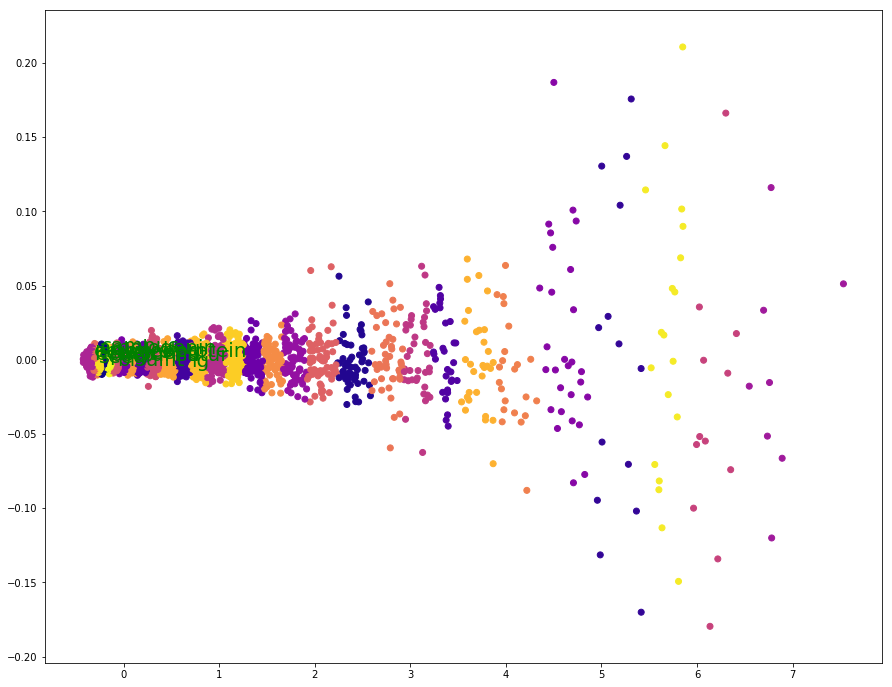

In [216]:
import random
plt.figure(figsize=(15,12))
plt.scatter(vectors2D_PCA[:,0],vectors2D_PCA[:,1], c= KM.predict(model.wv.vectors), cmap='plasma')
for i in [random.randint(0,10000) for i in range(10)]:
    plt.annotate(list(model.wv.vocab.keys())[i],vectors2D_PCA[i], color='green',size=20)
#plt.savefig('/Users/chalvidalm/Documents/3A OMA/Plateforme et Langage de Programmation/Etude_de_cas/Scikit_PCA_500K', bbox_inches="tight")

#### T_SNE

In [14]:
from sklearn.manifold import TSNE
start = time.time()
vectors2D = TSNE(n_components=2).fit_transform(model.wv.vectors)
t_TSNE_1000_scikit = time.time() - start

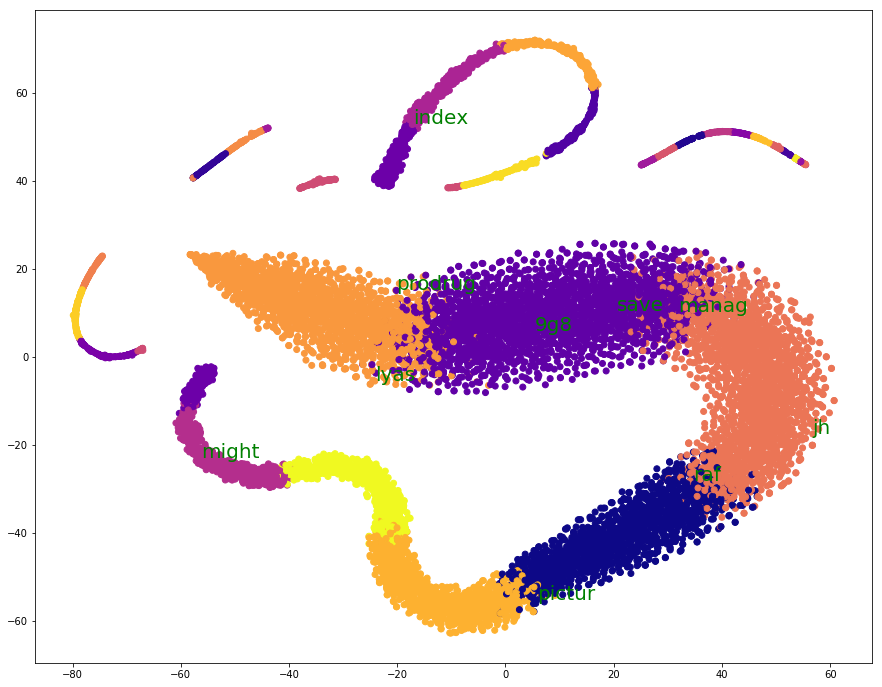

In [93]:
import random
plt.figure(figsize=(15,12))
plt.scatter(vectors2D[:,0],vectors2D[:,1], c= KM.predict(model.wv.vectors), cmap='plasma')
for i in [random.randint(0,10000) for i in range(10)]:
    plt.annotate(list(model.wv.vocab.keys())[i],vectors2D[i], color='green',size=20)
plt.savefig('/Users/chalvidalm/Documents/3A OMA/Plateforme et Langage de Programmation/Etude_de_cas/Scikit_TSNE', bbox_inches="tight")

## 2 - Spark implementation MLIB

**imports**

In [1]:
import pyspark
from pyspark.conf import SparkConf
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import HashingTF
from pyspark.ml.feature import IDF
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.types import *
from pyspark.ml.feature import Word2Vec, HashingTF, IDF

In [12]:
import findspark
findspark.init('/Users/chalvidalm/Documents/3A OMA/Plateforme et Langage de Programmation/cours 4 - Spark/spark-2.3.2-bin-hadoop2.7')

**Configuration of Spark context**

In [22]:
config = SparkConf()
config.setAll([('spark.driver.memory','1G'),
               ('spark.executor.memory','30g'),
               ('spark.master', 'local[*]'),
               ('spark.executor.cores', '4'),
               #('spark.cores.max', '100'),
               ('partitionNum','8')])
config.getAll()

[('spark.driver.memory', '1G'),
 ('spark.executor.memory', '30g'),
 ('spark.master', 'local[*]'),
 ('spark.submit.deployMode', 'client'),
 ('partitionNum', '8'),
 ('spark.app.name', 'pyspark-shell'),
 ('spark.executor.cores', '4'),
 ('spark.ui.showConsoleProgress', 'true')]

In [7]:
spark = SparkSession.builder.getOrCreate()
print(spark)

In [8]:
sql_spark = SQLContext.getOrCreate(config)
print(sql_spark)

**Cleaning and tokenization of dataset**

In [17]:

df = sql_spark.read.format("com.databricks.spark.csv").option("header", "true").load('/Users/chalvidalm/Documents/3A OMA/Plateforme et Langage de Programmation/Etude_de_cas/titlebased-semantic-subject-indexing/pubmed.csv').limit(10000)

from pyspark.sql.types import ArrayType
from pyspark.sql.functions import udf,col,lower
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover
from nltk.corpus import stopwords

def Racinisation(x):
    Sno = nltk.stem.SnowballStemmer('english')
    return Sno.stem(x)

def cleaning(df,name_col):
    # liste des mots à supprimer
    Stopwords = stopwords.words('English')
    start = time.time()
    reTokenizer = RegexTokenizer(inputCol="C4", outputCol="Tokens")
    df = reTokenizer.transform(df.withColumn('C4', lower(col('title'))))
    remover = StopWordsRemover(inputCol="Tokens", outputCol="Tokens_stem", stopWords = Stopwords)
    df = remover.transform(df)
    time_ = time.time() - start
    return df, time_ 

df, t_cleaning_1000_spark = cleaning(df,'title')

taux_donnees= 0.2
df_train, df_test = df.randomSplit([taux_donnees, 1 - taux_donnees])

**Vectorization Word2Vec**

In [18]:
start = time.time()
word2vec = Word2Vec(inputCol="Tokens", outputCol="features",vectorSize=100)
model_pyspark = word2vec.fit(df_train)
t_vecto_word2vec_1000_spark = time.time() - start

In [19]:
df_word2vec_test = model_pyspark.transform(df_test)
df_word2vec_train = model_pyspark.transform(df_train)

In [219]:
df_word2vec_train.schema

StructType(List(StructField(id,StringType,true),StructField(title,StringType,true),StructField(labels,StringType,true),StructField(fold,StringType,true),StructField(C4,StringType,true),StructField(Tokens,ArrayType(StringType,true),true),StructField(Tokens_stem,ArrayType(StringType,true),true),StructField(features,VectorUDT,true)))

In [160]:
df_word2vec_train = df_word2vec_train.toDF('id', 'title', 'labels','fold', 'C4', 'Tokens', 'Tokens_stem', 'features')
df_word2vec_train = df_word2vec_train.withColumn("label", df_word2vec_train["labels"].cast("double"))
df_word2vec_train = df_word2vec_train.withColumn("label", df_word2vec_train["labels"].cast("double"))
df_word2vec_test = df_word2vec_test.toDF('id', 'title', 'labels','fold', 'C4', 'Tokens', 'Tokens_stem', 'features')
df_word2vec_test = df_word2vec_test.withColumn("label", df_word2vec_test["labels"].cast("double"))
df_word2vec_train = df_word2vec_train.fillna(0, subset=df_word2vec_train.columns)

**k-Means + PCA**

In [20]:
from pyspark.ml.clustering import KMeans
start = time.time() 
kmeans = KMeans().setK(30).setSeed(1).setMaxIter(1000).setTol(0.0001)
KMSpark = kmeans.fit(df_word2vec_train.select('features'))
predictions = KMSpark.transform(df_word2vec_train.select('features'))
t_kmeans_1000_spark = time.time() - start
#predictions.toPandas()

In [21]:
from pyspark.ml.feature import PCA
pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
start = time.time()
model = pca.fit(df_word2vec_train.select('features'))
coords = model.transform(df_word2vec_train.select('features')).select("pcaFeatures")
t_PCA_1000_spark = time.time() - start
coord_spark = coords.toPandas()['pcaFeatures'].apply(lambda x : x.toArray()).values

In [224]:
coordonates_Spark = np.zeros((len(coord_spark),2))
for i, coor in enumerate(coord_spark):
    coordonates_Spark[i] = (float(coor[0]),float(coor[1]))

AttributeError: 'PCAModel' object has no attribute 'wv'

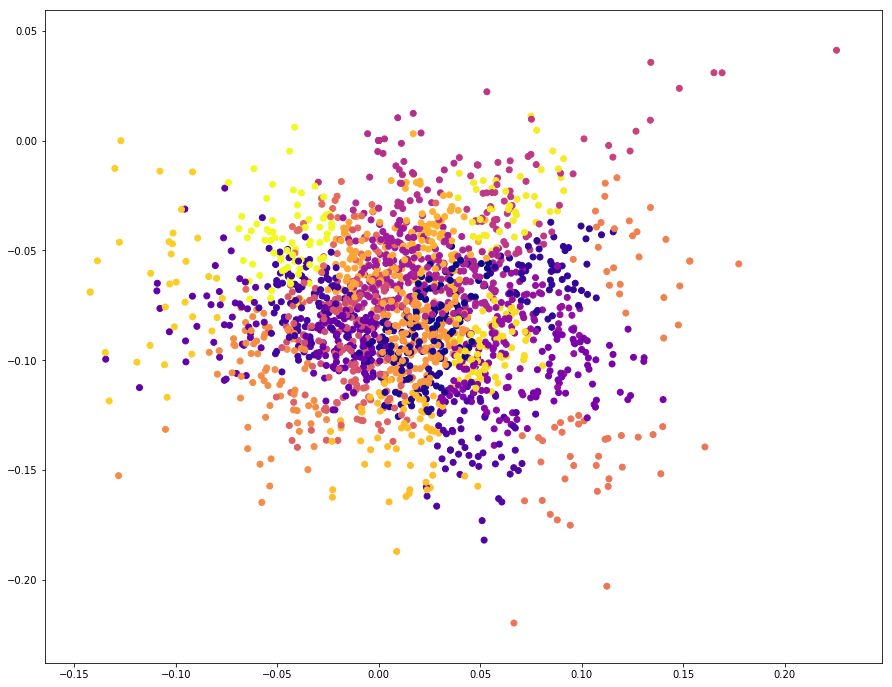

In [225]:
preds = np.array(predictions.toPandas()['prediction'].tolist())
plt.figure(figsize=(15,12))
plt.scatter(coordonates_Spark[:,0],coordonates_Spark[:,1], c=preds, cmap='plasma')
for i in [random.randint(0,10000) for i in range(10)]:
    plt.annotate(list(model.wv.vocab.keys())[i],vectors2D[i], color='green',size=20)
#plt.savefig('/Users/chalvidalm/Documents/3A OMA/Plateforme et Langage de Programmation/Etude_de_cas/PCA_Spark_500K', bbox_inches="tight")


#### T_SNE

There is no implementation of T_SNE on Pyspark at the moment.

#### Querying keyords 

In [228]:
model_pyspark.findSynonyms('blood', 5).collect()
t_query_1000_spark =0
for k in ['viral', 'blood', 'immune', 'brain', 'genetic']:
    start = time.time()
    model_pyspark.findSynonyms(k, 10).collect()
    t_query_1000_scikit = time.time() - start + t_query_1000_spark
t_query_1000_spark = t_query_1000_scikit/5

**Evaluating time performances**

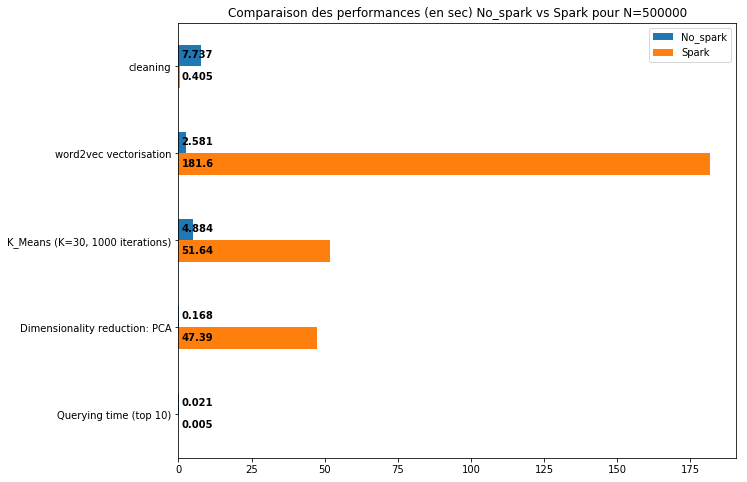

In [229]:
performance = pd.DataFrame(data = [[t_cleaning_1000_scikit,
                                    t_vecto_Word2Vec_1000_scikit,
                                    t_kmeans_1000_scikit,
                                    t_PCA_1000_scikit,
                                    t_query_1000_scikit],
                                   [t_cleaning_1000_spark,
                                    t_vecto_word2vec_1000_spark,
                                    t_kmeans_1000_spark,
                                    t_PCA_1000_spark,
                                    t_query_1000_spark]], 
                           index = ['No_spark','Spark'],
                           columns=['cleaning',
                                    'word2vec vectorisation',
                                    'K_Means (K=30, 1000 iterations)',
                                    'Dimensionality reduction: PCA',
                                    'Querying time (top 10)']).transpose()

a = performance.plot.barh(figsize=(10,8), title='Comparaison des performances (en sec) No_spark vs Spark pour N=500000', rot= 'horizontal')
a.invert_yaxis()

values = [t_cleaning_1000_scikit,
          t_vecto_Word2Vec_1000_scikit,
          t_kmeans_1000_scikit,
          t_PCA_1000_scikit,
          t_query_1000_scikit,
          t_cleaning_1000_spark,
          t_vecto_word2vec_1000_spark,
          t_kmeans_1000_spark,
          t_PCA_1000_spark,
          t_query_1000_spark]

for j, i in enumerate(a.patches):
        a.text(0.01*i.get_y()+1, i.get_y()+0.15, str(values[j])[0:5], fontsize=10,color='black',fontweight='bold' )

#plt.savefig('/Users/chalvidalm/Documents/3A OMA/Plateforme et Langage de Programmation/Etude_de_cas/performance temporelle_500K', bbox_inches="tight")